# Recommending movies (based on user demographics and movie info)
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.ipython.org/github/david-cortes/datascienceprojects/blob/master/machine_learning/recommender_system_w_coldstart.ipynb)*

This project consists of recommending movies to users based on their demographic information (in this case: age, gender, occupation and geographical region) and on movie information (in this case: year of production, genres, and user tags), using the [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/) dataset, which contains 1,000,209 ratings of 3,900 movies from 6,040 users, along with the users’ demographic information and some basic movie information; enhancing the movie info with the [MovieLens 20M](https://grouplens.org/datasets/movielens/20m/) dataset, which contains more detailed movie information in the form of _tag genomes_ as described in [Vig, J., Sen, S., & Riedl, J. (2012). The tag genome: Encoding community knowledge to support novel interaction. ACM Transactions on Interactive Intelligent Systems (TiiS), 2(3), 13.](http://dl.acm.org/citation.cfm?id=2362395).

The formula used is an implementation of what’s described in [Park, S. T., & Chu, W. (2009, October). Pairwise preference regression for cold-start recommendation. In Proceedings of the third ACM conference on Recommender systems (pp. 21-28). ACM.]( http://dl.acm.org/citation.cfm?id=1639720), with some slight modifications – the general idea is to produce a regression on differences between ratings of two movies from the same user using the outer products of the user and movie attribute vectors.

In comparison to recommendations based on past user ratings, these kinds of models are able to provide quality recommendations to new users (for whom there is demographic information available), and are able to recommend both old and new movies (as long as there is information about them).

The idea implemented here differs from what the paper above describes in that:
* More movie information is added through the use of the _tag genome_ info.
* No rating bots are used to enhance movie features.
* For computational reasons, the results will only be evaluated with rating averages of the movies that would be recommended for a hold-out user set.

## Recommendation formula

This model consists on ranking movies for a user by a linear combination of the outer product of movie and user features multiplied by some weights that minimize the squares of differences between ratings of each two movies minus predicted differences, plus a regularization term - this is given by the following formula:

$$ \min_w  \sum_{u \in users} \bigg( \frac{1}{\left\vert\ M_u \right\vert} \sum_{i \in M_u} \sum_{j \in M_u} (\:(R_{ui} - R_{uj}) - (w^\mathsf{T}(z_i \otimes x_u) - w^\mathsf{T}(z_j \otimes x_u)\:)^2 \bigg) + \lambda \lVert w \rVert^2_2  $$

Where $R_{ui}$ are the ratings given by users to movies, $x$ are the user features, $z$ are the movie features, $M_{user}$ are the movies that have been rated by a given user, $\lambda$ is a regularization term, and $w$ are the coefficients assigned to each combination of user-movie feature. Note that the optimization problem is convex with respect to $w$.

Recommendations are then produced for each user by calculating, for each movie, $w^\mathsf{T}(z_j \otimes x_u)$ and taking the movies with highest such score for that user.

Intuitively, the parameters that minimize such a loss function would be exactly the same that minimize a regression of the centered ratings for each user, that is:

$$ \min_w \sum_{u \in users} \frac{1}{\left\vert\ M_u \right\vert} \sum_{i \in M_u} \bigg( (R_{ui} - \overline{R_u}) - w^\mathsf{T}(z_i \otimes x_u)  \bigg)^2 + \lambda \lVert w \rVert^2_2 $$

This is far easier and faster to work with, and can be easily computed with standard libraries. I found the formula without weights by movies rated per user to be slightly more accurate after optimizing the coefficients for half an hour.

## Sections

[1. Processing the movie data](#p1)

[2. Processing the user data](#p2)

[3. Loading ratings and generating test set](#p3)

[4. Fitting the model with Spark](#p4)

[5. Evaluating the model and checking some recommendations](#p5)
** *

<a id="p1"></a>
## 1. Processing the movie data


The movie data needs some processing in order to put it in the right format.
As explained before, the movie data can be enhanced with the tag genome information, which contains 1128 tags for each movie in a relative scale from 0 to 1 (with values closer to 1 indicating that the movie has more of that tag). Although these are way too many tags to use with this small ratings data, many tags are relate to each other and it’s possible to make some good feature reduction using principal components.

A small look at the data:

In [1]:
import pandas as pd, numpy as np, re
from collections import defaultdict

movies=pd.read_csv('/home/david/movielens/ml-latest/ml-latest/movies.csv')
movies_humanreadable=movies.copy()
movies['hasYear']=movies.title.map(lambda x: bool(re.search("\s\((\d{4})\)$",x.strip())))
movies['Year']='unknown'
movies['Year'].loc[movies.hasYear]=movies.title.loc[movies.hasYear].map(lambda x: re.search("\s\((\d{4})\)$",x.strip()).group(1))
del movies['hasYear']
movies.head()

/home/david/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,movieId,title,genres,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [2]:
movies['genres']=movies.genres.map(lambda x: set(x.split('|')))
present_genres=set()
for movie in movies.itertuples():
    present_genres=present_genres.union(movie.genres)
for genre in present_genres:
    movies['genre'+genre]=movies.genres.map(lambda x: 1.0*(genre in x))
present_genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

Processing the tag genome info:

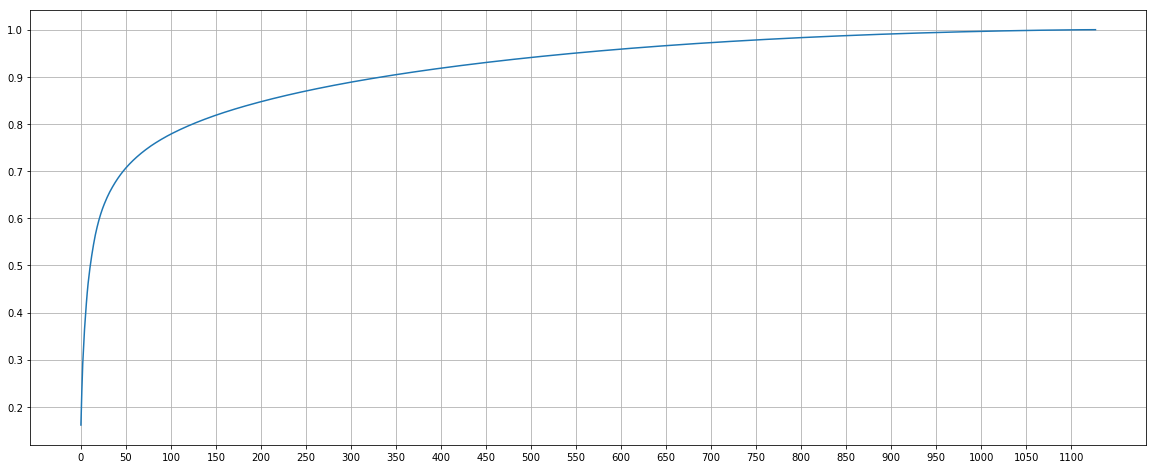

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

tags=pd.read_csv('/home/david/movielens/ml-latest/ml-latest/genome-scores.csv')
tags_wide=tags.pivot(index='movieId', columns='tagId', values='relevance')
tags_wide=tags_wide.fillna(0)
pca=PCA(svd_solver='full')
pca.fit(tags_wide)

plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0.2, 1.1, .1))
plt.xticks(np.arange(0, 1128, 50))
plt.grid()

From this figure, it seems that 50 tags or so would be a good number to include.

In [4]:
tags_pca=pd.DataFrame(pca.transform(tags_wide)[:,:50])
tags_pca.columns=["pc"+str(x) for x in tags_pca.columns.values]
tags_pca['movieId']=tags_wide.index
movies=pd.merge(movies,tags_pca,how='inner',on='movieId')

The year is converted into a discrete variable using the same criteria as in the original paper - the ratings were taken around the year 2000 so it makes sense to use these limits, in order to identify what were more recent movies at that time (which comprise the majority of the ratings).

In [5]:
## these criteria for making year discrete were taken from the same paper describing the method
def discretize_year(x):
    if x=='unknown':
        return x
    else:
        x=int(x)
        if x>=2000:
            return '>=2000'
        if x>=1995 and x<=1999:
            return str(x)
        if x>=1990 and x<=1994:
            return 'low90s'
        if x>=1980 and x<=1989:
            return '80s'
        if x>=1970 and x<=1979:
            return '70s'
        if x>=1960 and x<=1969:
            return '60s'
        if x>=1950 and x<=1959:
            return '50s'
        if x>=1940 and x<=1959:
            return '40s'
        if x<1940:
            return '<1940'
        else:
            return 'unknown'

movies_features=movies.copy()
del movies_features['title']
del movies_features['genres']
del movies_features['genre(no genres listed)']
movies_features['Year']=movies_features.Year.map(lambda x: discretize_year(x))
movies_features=pd.get_dummies(movies_features, columns=['Year'])
movies_features.set_index('movieId',inplace=True)
movies_features.head()

,genreMystery,genreSci-Fi,genreCrime,genreDrama,genreAnimation,genreIMAX,genreAction,genreComedy,genreDocumentary,genreWar,...,Year_1999,Year_40s,Year_50s,Year_60s,Year_70s,Year_80s,Year_<1940,Year_>=2000,Year_low90s,Year_unknown
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


<a id="p2"></a>
## 2. Processing the user data

The dataset contains demographic info with zip codes. As there are way too many of them, I’ll try to guess the US region from these zipcodes. In order to do so, I’m using a [publicly available table](http://federalgovernmentzipcodes.us/) mapping zip codes to states, [another one](http://www.fonz.net/blog/archives/2008/04/06/csv-of-states-and-state-abbreviations/) mapping state names to their abbreviations, and finally classifying the states into regions according to [usual definitions](https://www.infoplease.com/us/states/sizing-states).

In [6]:
zipcode_abbs=pd.read_csv("/home/david/movielens/zips/states.csv")
zipcode_abbs_dct={z.State:z.Abbreviation for z in zipcode_abbs.itertuples()}
us_regs_table=[
    ('New England', 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont'),
    ('Middle Atlantic', 'Delaware, Maryland, New Jersey, New York, Pennsylvania'),
    ('South', 'Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, Missouri, North Carolina, South Carolina, Tennessee, Virginia, West Virginia'),
    ('Midwest', 'Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin'),
    ('Southwest', 'Arizona, New Mexico, Oklahoma, Texas'),
    ('West', 'Alaska, California, Colorado, Hawaii, Idaho, Montana, Nevada, Oregon, Utah, Washington, Wyoming')
    ]
us_regs_table=[(x[0],[i.strip() for i in x[1].split(",")]) for x in us_regs_table]
us_regs_dct=dict()
for r in us_regs_table:
    for s in r[1]:
        us_regs_dct[zipcode_abbs_dct[s]]=r[0]

In [7]:
zipcode_info=pd.read_csv("/home/david/movielens/free-zipcode-database.csv")
zipcode_info=zipcode_info.groupby('Zipcode').first().reset_index()
zipcode_info['State'].loc[zipcode_info.Country!="US"]='UnknownOrNonUS'
zipcode_info['Region']=zipcode_info['State'].copy()
zipcode_info['Region'].loc[zipcode_info.Country=="US"]=zipcode_info.Region.loc[zipcode_info.Country=="US"].map(lambda x: us_regs_dct[x] if x in us_regs_dct else 'UsOther')
zipcode_info=zipcode_info[['Zipcode', 'Region']]
zipcode_info.head()

/home/david/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Zipcode,Region
0,501,Middle Atlantic
1,544,Middle Atlantic
2,601,UsOther
3,602,UsOther
4,603,UsOther


A small look the the demographic data provided in the dataset:

In [8]:
users=pd.read_table("/home/david/movielens/ml-1m/ml-1m/users.dat",sep='::',names=["userId","Gender","Age","Occupation","Zipcode"], engine='python')
users["Zipcode"]=users.Zipcode.map(lambda x: np.int(re.sub("-.*","",x)))
users=pd.merge(users,zipcode_info,on='Zipcode',how='left')
users['Region']=users.Region.fillna('UnknownOrNonUS')
users.head()

,userId,Gender,Age,Occupation,Zipcode,Region
0,1,F,1,10,48067,Midwest
1,2,M,56,16,70072,South
2,3,M,25,15,55117,Midwest
3,4,M,45,7,2460,New England
4,5,M,25,20,55455,Midwest


In [9]:
users.Region.value_counts()

West               1652
Midwest            1546
South               887
Middle Atlantic     872
New England         507
Southwest           462
UnknownOrNonUS       73
UsOther              41
Name: Region, dtype: int64

In [10]:
users_features=users.copy()
users_features['Gender']=users_features.Gender.map(lambda x: 1.0*(x=='M'))
del users_features['Zipcode']
users_features['Age']=users_features.Age.map(lambda x: str(x))
users_features['Occupation']=users_features.Occupation.map(lambda x: str(x))
users_features=pd.get_dummies(users_features, columns=['Age', 'Occupation', 'Region'])
users_features.set_index('userId',inplace=True)
users_features.head()

,Gender,Age_1,Age_18,Age_25,Age_35,Age_45,Age_50,Age_56,Occupation_0,Occupation_1,...,Occupation_8,Occupation_9,Region_Middle Atlantic,Region_Midwest,Region_New England,Region_South,Region_Southwest,Region_UnknownOrNonUS,Region_UsOther,Region_West
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


<a id="p3"></a>
## 3. Loading ratings and generating test set

A small look at the ratings provided:

In [11]:
ratings=pd.read_table("/home/david/movielens/ml-1m/ml-1m/ratings.dat", sep="::", names=["userId","movieId","Rating","Timestamp"], engine='python')
movies_w_sideinfo=set(list(movies.movieId))
ratings=ratings.loc[ratings.movieId.map(lambda x: x in movies_w_sideinfo)]
ratings.head()

,userId,movieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Generating a train and test set - for computational reasons I'll just take 100 random users as test with all the movies they rated:

In [12]:
userids_present=list(set(list(ratings.userId)))
np.random.seed(1)
users_testset=set(list(np.random.choice(userids_present,replace=False,size=100)))

ratings_train=ratings.loc[ratings.userId.map(lambda x: x not in users_testset)]
ratings_test=ratings.loc[ratings.userId.map(lambda x: x in users_testset)]
users_trainset=set(list(ratings.userId.loc[ratings.userId.map(lambda x: x not in users_testset)]))

# now centering the ratings
avg_rating_by_user=ratings_train.groupby('userId')['Rating'].mean().to_frame().rename(columns={'Rating':'AvgRating'})
ratings_train=pd.merge(ratings_train, avg_rating_by_user, left_on='userId',right_index=True)
ratings_train['RatingCentered']=ratings_train.Rating-ratings_train.AvgRating

print(ratings_train.shape[0])
print(ratings_test.shape[0])

978017
18866


<a id="p4"></a>
## 4. Fitting the model with Spark

The data is very high-dimensional and doesn't fit in a computer's RAM memory, thus Spark comes very handy for the computations, even when run locally. As it takes a long time to compute the coefficients, this will be done without any hyperparameter tuning.

Starting Spark:

In [13]:
import findspark

findspark.init("/home/david/Downloads/spark-2.1.1-bin-hadoop2.7/")

import pyspark
sc = pyspark.SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

Now fitting the model:

In [14]:
from pyspark.mllib.regression import (LabeledPoint, RidgeRegressionWithSGD)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from scipy.sparse import csc_matrix

def generate_features(user,movie,users_features_bc,movies_features_bc):
    user_feats=users_features_bc.value.loc[user].as_matrix()
    movie_feats=movies_features_bc.value.loc[movie].as_matrix()
    return csc_matrix(np.kron(user_feats,movie_feats).reshape(-1,1))

users_features_bc=sc.broadcast(users_features)
movies_features_bc=sc.broadcast(movies_features)

trainset=sc.parallelize([(i.userId,i.movieId,i.RatingCentered) for i in ratings_train.itertuples()])\
.map(lambda x: LabeledPoint(x[2],generate_features(x[0],x[1],users_features_bc,movies_features_bc)))\
.map(lambda x: (float(x.label),x.features.asML())).toDF(['label','features'])
trainset.repartition(50)

recommender=LinearRegression(regParam=1e-4).fit(trainset)
formula_coeffs=recommender.coefficients.toArray()

<a id="p5"></a>
## 5. Evaluating the model and checking some recommendations

Finally, evaluating what this system recommends to users. Due to the computational time it takes, the results won’t be evaluated with the metrics proposed in the paper at the beginning. I’ll just take average ratings for top-5 recommendations for each user in the test set and compare them to average ratings (the expected value for random recommendations) and to the maximum possible ratings from 5 movies each.

This is not a really good measure, but it’s a good sense check to see if the recommendations are making sense and if the system is better than nothing.
** *
Getting scores for the test set:

In [15]:
def generate_features_series(user,movie):
    user_feats=users_features.loc[user].as_matrix()
    movie_feats=movies_features.loc[movie].as_matrix()
    return pd.Series(np.kron(user_feats,movie_feats).astype('float64'))

X_test=ratings_test.apply(lambda x: generate_features_series(x['userId'],x['movieId']), axis=1)
ratings_test['score']=X_test.dot(formula_coeffs)

/home/david/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Comparing the model to recommending the most popular movies too:

In [16]:
avg_ratings=ratings.groupby('movieId')['Rating'].mean().to_frame().rename(columns={"Rating":"AvgRating"})
ratings_test=pd.merge(ratings_test,avg_ratings,left_on='movieId',right_index=True)

Now comparing it to no model (random recommendation) and best possible recommendations (in terms of ratings):

In [17]:
print 'Averge movie rating:',ratings_test.groupby('userId')['Rating'].mean().mean()
print 'Average rating for top-5 rated by each user:',ratings_test.sort_values(['userId','Rating'],ascending=False).groupby('userId')['Rating'].head(5).mean()
print 'Average rating for bottom-5 rated by each user:',ratings_test.sort_values(['userId','Rating'],ascending=True).groupby('userId')['Rating'].head(5).mean()
print 'Average rating for top-5 recommendations of best-rated movies:',ratings_test.sort_values(['userId','AvgRating'],ascending=False).groupby('userId')['Rating'].head(5).mean()
print '----------------------'
print 'Average rating for top-5 recommendations from this model:',ratings_test.sort_values(['userId','score'],ascending=False).groupby('userId')['Rating'].head(5).mean()
print 'Average rating for bottom-5 (non-)recommendations from this model:',ratings_test.sort_values(['userId','score'],ascending=True).groupby('userId')['Rating'].head(5).mean()

Averge movie rating: 3.68455396497
Average rating for top-5 rated by each user: 4.96
Average rating for bottom-5 rated by each user: 1.61
Average rating for top-5 recommendations of best-rated movies: 4.416
----------------------
Average rating for top-5 recommendations from this model: 4.338
Average rating for bottom-5 (non-)recommendations from this model: 2.554


Examining some recommendations (3 per user):

In [18]:
top3=ratings_test.sort_values(['userId','score'],ascending=False).groupby('userId').head(3)
top3=top3[['userId','movieId','Rating']]
top3=pd.merge(top3,users,on='userId',how='left')
top3=pd.merge(top3,movies_humanreadable,on='movieId',how='left')
top3.rename(columns={'title':'Recommended Movie', 'genres':"Movie's Genres", 'Rating':'Rating by user'},inplace=True)
age_mapping={
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}
top3['Age']=top3.Age.map(lambda x: age_mapping[x])
occupations_mapping={
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}
top3['Occupation']=top3.Occupation.map(lambda x: occupations_mapping[x])
del top3['Zipcode']
del top3['movieId']
top3[['userId','Recommended Movie','Rating by user', 'Gender','Age','Occupation','Region',"Movie's Genres"]]

,userId,Recommended Movie,Rating by user,Gender,Age,Occupation,Region,Movie's Genres
0,5938,Raiders of the Lost Ark (Indiana Jones and the...,5,M,25-34,academic/educator,South,Action|Adventure
1,5938,"Usual Suspects, The (1995)",5,M,25-34,academic/educator,South,Crime|Mystery|Thriller
2,5938,North by Northwest (1959),5,M,25-34,academic/educator,South,Action|Adventure|Mystery|Romance|Thriller
3,5798,Raiders of the Lost Ark (Indiana Jones and the...,4,M,35-44,other or not specified,West,Action|Adventure
4,5798,Saving Private Ryan (1998),5,M,35-44,other or not specified,West,Action|Drama|War
5,5798,"Godfather, The (1972)",5,M,35-44,other or not specified,West,Crime|Drama
6,5693,North by Northwest (1959),4,F,25-34,college/grad student,West,Action|Adventure|Mystery|Romance|Thriller
7,5693,Schindler's List (1993),3,F,25-34,college/grad student,West,Drama|War
8,5693,Notorious (1946),3,F,25-34,college/grad student,West,Film-Noir|Romance|Thriller
9,5692,"Shawshank Redemption, The (1994)",5,F,25-34,executive/managerial,South,Crime|Drama


Note that this was a complete-user hold-out test set (the model's parameters were not calculated using any information from these users and might not even have used any information from the movies that are being recommended), but the recommendations shown here are limited to only the movies that each of these users have rated in order to be able to see how they would have rated the recommendations.

As the top-5 recommendations for each user seem to have been well rated by them, we might guess they are good. They might not be rated as highly as simply recommending the best-rated movies, but the recommendations are personalized and can recommend newer movies too (as long as they have tags).

As for implementing such a model, since it generates the same recommendations for any user with the same combination of gender, age, occupation and location, the recommendations could be pre-computed for each of the $2 \times 7 \times 21 \times 8=2352$ theoreticall buckets (in reality, not all of them make sense though, as people of certain ages - such as under 18 - shouldn't fall into certain occupations).